In [2]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
%matplotlib notebook

The .h5 files to actually try spike sorting. 

In [3]:
filedirec = r"D:\Files_Reutlingen_Jenny\191021_extra"
os.chdir(filedirec)

In [4]:
filelist = glob.glob('*.h5')
filelist

['aCSF_adult_15min_spont.h5',
 'hCSF_adult_20min_spont0002.h5',
 'hCSF_child_20min_spont.h5']

In [5]:
filename=filelist[0]

First problem is: We need a probe file, that takes the random configuration of channels of the MCS - MEA System into account. Let us first review the 'order' MCS channeles: 

In [6]:
channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirec, filename))


In [7]:
# find out, where our channel labels are hiding
channel_raw_data.recordings[0].analog_streams[0].channel_infos[1]
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]


Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 22500000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 22500000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


In [8]:
ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


Here is the channel_id

In [9]:
# here we find in the info part of channel infos all we search: info is a dictionary which
# has the 'Label' key
channel_raw_data.recordings[0].analog_streams[0].channel_infos[0].info


{'ChannelID': 0,
 'RowIndex': 0,
 'GroupID': 0,
 'ElectrodeGroup': 0,
 'Label': 'R12',
 'RawDataType': 'Int',
 'Unit': 'V',
 'Exponent': -12,
 'ADZero': 0,
 'Tick': 40,
 'ConversionFactor': 104166,
 'ADCBits': 16,
 'HighPassFilterType': '',
 'HighPassFilterCutOffFrequency': '-1',
 'HighPassFilterOrder': -1,
 'LowPassFilterType': '',
 'LowPassFilterCutOffFrequency': '-1',
 'LowPassFilterOrder': -1}

In [10]:
def get_label_dictionary_from_MCS_channel_infos(np_analog_for_filter, analog_stream_0):


    label_dictionary ={}

    for i in range(0, len(np_analog_for_filter)):
        channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[channel_idx]
        channel_info = analog_stream_0.channel_infos[channel_id]
        label_dictionary[channel_id]=channel_info.info['Label']
   
    return label_dictionary

Extracting infor from recording:



# MEA DATA

In [11]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(filedirec, filename))

In [12]:
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [13]:
recording_MEA.get_channel_property_names(channel_id=0)

['group']

In [14]:
w_ts = sw.plot_timeseries(recording_cmr, trange=[0,5])
#w_rs = sw.plot_rasters(sorting_true, trange=[0,5])

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [15]:
print('Num. channels = {}'.format(len(recording_MEA.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording_MEA.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording_MEA.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording_MEA.get_traces(channel_ids=2))))
print('Location of third electrode = {}'.format(recording_MEA.get_channel_property(channel_id=2, property_name='location')))

Num. channels = 252
Sampling frequency = 24999.999999999996 Hz
Num. timepoints = 22500000
Stdev. on third channel = 4.436484652799032e-06
Location of third electrode = [nan nan]


In [64]:
np.shape(recording_cmr.get_traces())

KeyboardInterrupt: 

In [16]:
recording_cmr.get_channel_property_names(channel_id=10)

['group']

In [17]:
recording_cmr.get_channel_locations()

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan,

In [18]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [19]:
recording_cmrprobe.get_channel_property_names(channel_id=0)


['group', 'location']

In [20]:
recording_cmrprobe.get_channel_locations()

array([[3000.,  800.],
       [2000., 1200.],
       [2600., 1200.],
       [2800., 1000.],
       [2000., 1400.],
       [2400., 1400.],
       [2200., 1600.],
       [3000., 1600.],
       [2600., 2000.],
       [2400., 1800.],
       [3000., 2400.],
       [2800., 2200.],
       [3000., 2800.],
       [2200., 2200.],
       [1800., 2000.],
       [1600., 1600.],
       [2000., 2800.],
       [2200., 3000.],
       [1600., 2400.],
       [1800., 2600.],
       [1400., 3000.],
       [1600., 2000.],
       [1200., 2400.],
       [1400., 2200.],
       [ 800., 2800.],
       [1000., 2600.],
       [2400.,  600.],
       [2600.,  400.],
       [3000.,  600.],
       [2000., 1000.],
       [2600., 1000.],
       [2800.,  800.],
       [2200., 1400.],
       [2400., 1200.],
       [2000., 1600.],
       [3000., 1400.],
       [2600., 1800.],
       [2400., 1600.],
       [3000., 2200.],
       [2800., 2000.],
       [1800., 1800.],
       [2000., 1800.],
       [2400., 2400.],
       [260

<IPython.core.display.Javascript object>


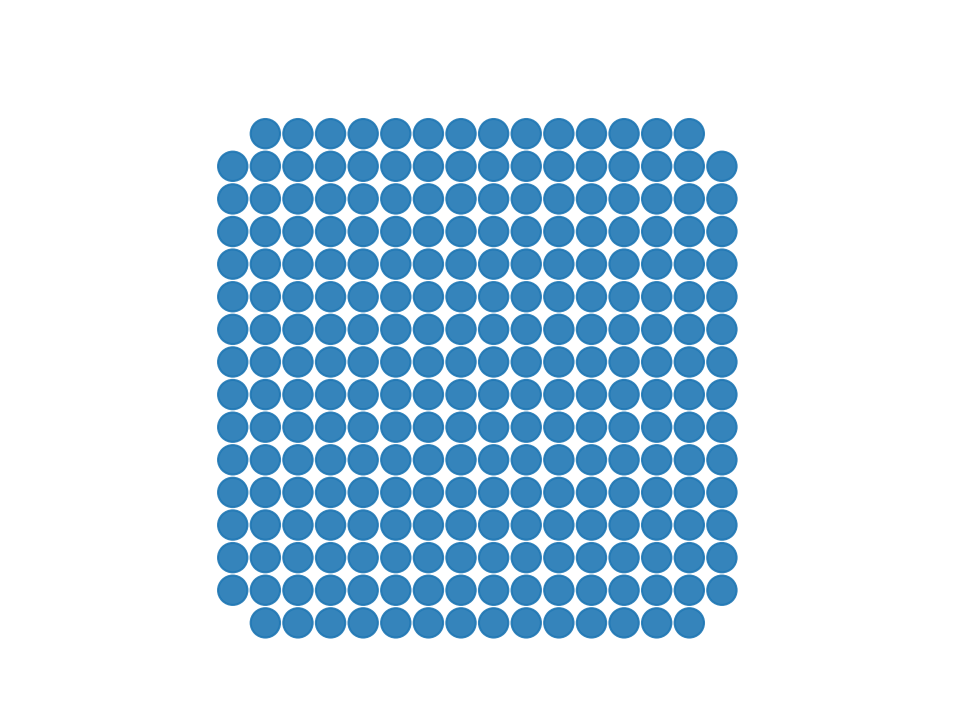

In [21]:
sw.plot_electrode_geometry(recording_cmrprobe, color='C0', label_color='r', figure=None, ax=None)

In [22]:
recording_cmrprobe.get_shared_channel_property_names()

['group', 'location']

In [23]:
probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"

In [24]:
outputdirectory_SC='D:/Files_Reutlingen_Jenny/191021_extra_Spikesorting/output_Spykingcirucs'
outputdirectory_phy='D:/Files_Reutlingen_Jenny/191021_extra_Spikesorting/output_exportphy'

outputdirectory_HS='D:/Files_Reutlingen_Jenny/191021_extra_Spikesorting/output_HS'
outputdirectory_HS_phy='D:/Files_Reutlingen_Jenny/191021_extra_Spikesorting/output_HS_exportphy'

In [25]:
print(ss.installed_sorters())


['herdingspikes', 'spykingcircus']


In [26]:
ss.get_default_params("herdingspikes")

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [33]:
ss.get_default_params("spykingcircus")

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [34]:
# SpyKING Circus spike sorting
sorting_SC = ss.run_spykingcircus(recording_cmrprobe, output_folder=outputdirectory_SC)
sorting_curated = st.curation.threshold_num_spikes(sorting=sorting_SC, threshold=10, threshold_sign='less')
st.postprocessing.export_to_phy(recording=recording_cmrprobe, sorting=sorting_curated, output_folder=outputdirectory_phy)


print('Units found with Spyking Circus:', sorting_SC.get_unit_ids())

RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\191021_extra_Spikesorting\output_Spykingcirucs\run_spykingcircus.bat
You can run spiketoolkit.preprocessing.bandpass_filter(recording, cache_to_file=True)
Recomputing info
Units found with Spyking Circus: [0, 1, 10, 100, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 101, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 102, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 103, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 104, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 105, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 106, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 107, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 108, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 109, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 11, 110, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 111, 1110, 1111, 

The initial file was 7.58 GB big and contained a 15 minute spontaneous recording. The output in total was 64.1 GB, including 21.5 GB from Spyking Circus, and 42.6 GB for postprocessing as export for phy. 

In [ ]:
#HerdingSpikes spike sorting
sorting_HS = ss.run_herdingspikes(recording_cmrprobe, output_folder=outputdirectory_HS, filter=False)
sorting_curated = st.curation.threshold_num_spikes(sorting=sorting_HS, threshold=10, threshold_sign='less')
st.postprocessing.export_to_phy(recording=recording_cmrprobe, sorting=sorting_curated, output_folder=outputdirectory_HS_phy)


print('Units found with Herding Spikes:', sorting_SC.get_unit_ids())

# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 24999
# Localization On
# Number of recorded channels: 252
# Analysing frames: 22500000; Seconds: 900.0360014400576
# Frames before spike in cutout: 7
# Frames after spike in cutout: 45
# tcuts: 32 70
# tInc: 100000
# Analysing frames from -32 to 100070  (0.0%)


<IPython.core.display.Javascript object>


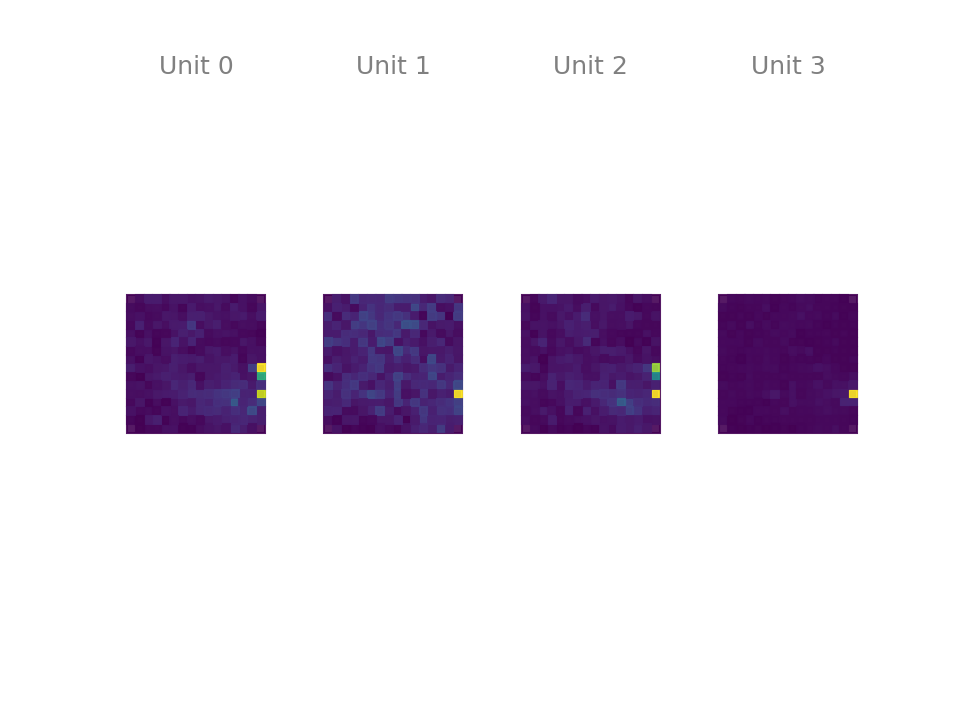

In [36]:
sw.plot_unit_template_maps(recording_cmrprobe,  sorting_SC, max_spikes_per_unit=100, unit_ids=[0,1,2,3])

<IPython.core.display.Javascript object>


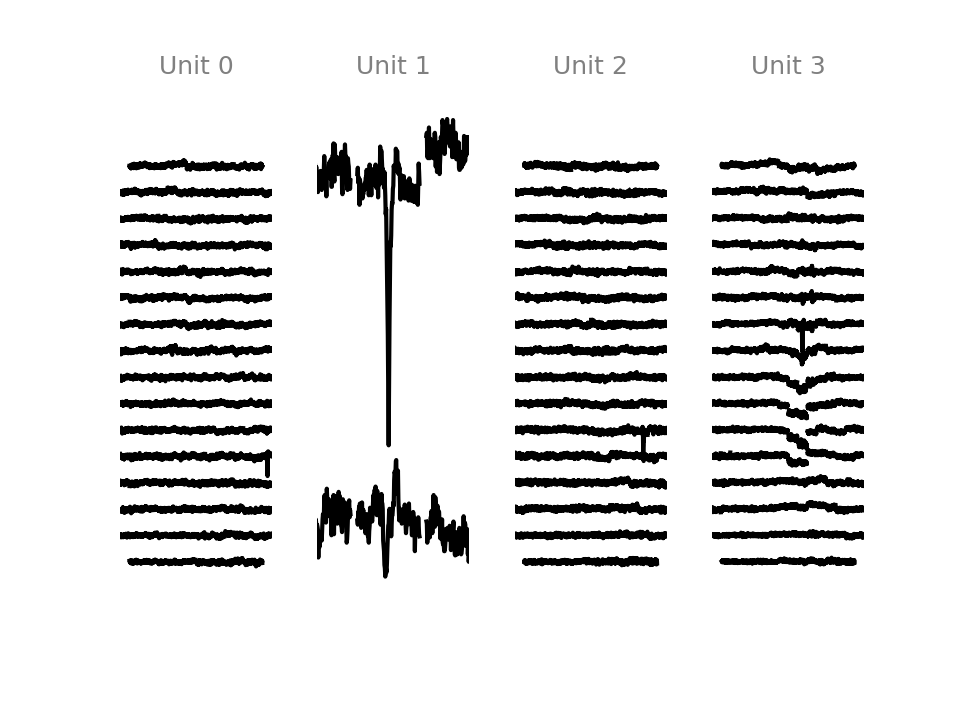

{'max_spikes_per_unit': 100}


In [64]:
sw.plot_unit_templates(recording_MEAprobe,  sorting_SC, max_spikes_per_unit=100, unit_ids=[0,1,2,3])

<IPython.core.display.Javascript object>


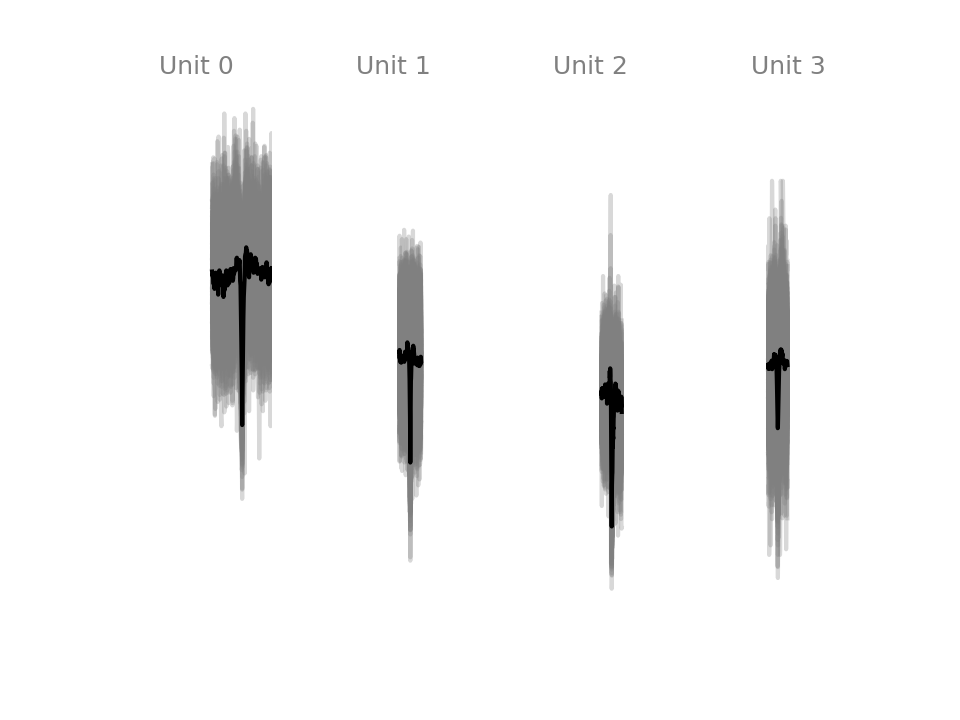

{}


In [58]:
sw.plot_unit_waveforms(recording=recording_MEAprobe, sorting=sorting_SC, unit_ids=[0,1,2,3], max_channels=1)

<IPython.core.display.Javascript object>


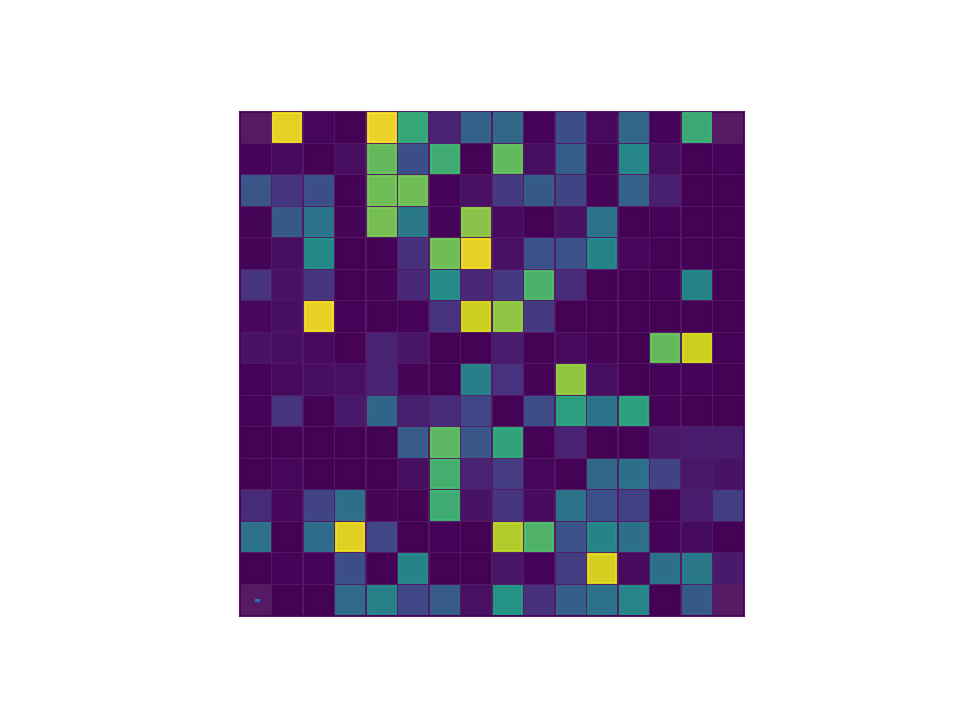

In [38]:
sw.plot_activity_map(recording_cmrprobe, log=True)

In [ ]:
isi_violations = st.validation.compute_isi_violations(sorting_SC, duration_in_frames=recording.get_num_frames(), isi_threshold=0.0015)
snrs = st.validation.compute_snrs(recording=recording_cmrprobe, sorting=sorting_SC, max_spikes_per_unit_for_snr=1000)
nn_hit_rate, nn_miss_rate = st.validation.compute_nn_metrics(recording=recording, sorting=sorting, num_channels_to_compare=13)

# Validation of Spikesorting

Next things:

- why are some channels empty? 
- How can we map that outcome?
- can I get spiketrains from this data?

In [6]:
os.chdir(outputdirectory_phy)

In [7]:
spike_times=np.load('spike_times.npy', allow_pickle=True)

In [8]:
spike_times


array([[     110],
       [     110],
       [     131],
       ...,
       [22499962],
       [22499962],
       [22499962]], dtype=uint32)

In [9]:
spike_times[-1]*40*1e-6

array([899.99848])

In [10]:
spike_clusters = np.load('spike_clusters.npy', allow_pickle=True)

In [11]:
spike_clusters

array([[1439],
       [1379],
       [ 587],
       ...,
       [ 996],
       [ 495],
       [ 999]], dtype=uint32)

In [12]:
np.unique(spike_clusters) # i.e. the clusters detected

array([   0,    1,    2, ..., 1454, 1455, 1456], dtype=uint32)

In [13]:
spike_templates = np.load('spike_templates.npy', allow_pickle=True)

In [14]:
np.shape(spike_templates)

(1942902, 1)

In [15]:
spike_templates

array([[1439],
       [1379],
       [ 587],
       ...,
       [ 996],
       [ 495],
       [ 999]], dtype=uint32)

In [16]:
spike_clusters

array([[1439],
       [1379],
       [ 587],
       ...,
       [ 996],
       [ 495],
       [ 999]], dtype=uint32)

In [17]:
amplitudes=np.load('amplitudes.npy', allow_pickle=True)

In [18]:
amplitudes[0]


array([1.1562426e-05], dtype=float32)

In [19]:
template_ind=np.load('template_ind.npy', allow_pickle=True)

In [20]:
template_ind

array([[ 35,  71,  75, ...,   3,  74,   2],
       [  0,   3,  64, ...,  28,  98, 101],
       [ 20, 117,  19, ..., 121,  91,  52],
       ...,
       [236, 240, 144, ..., 169, 237, 239],
       [236, 240, 144, ..., 169, 237, 239],
       [236, 240, 144, ..., 169, 237, 239]], dtype=int64)

In [21]:
np.unique(template_ind) # seems to be the channel ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
templates=np.load('templates.npy', allow_pickle=True)

In [23]:
np.shape(templates) # first array = templates, second array=

(1457, 148, 16)

In [24]:
templates[0][0]

array([1.249992e-06, 2.291652e-06, 2.395818e-06, 7.291620e-07,
       2.083320e-06, 1.874988e-06, 2.812482e-06, 3.541644e-06,
       4.166640e-07, 1.979154e-06, 2.916648e-06, 2.812482e-06,
       3.645810e-06, 4.479138e-06, 1.041660e-06, 4.374972e-06],
      dtype=float32)

In [25]:
templates[1]


array([[ 7.291620e-07,  1.041660e-06, -3.124980e-07, ..., -1.041660e-06,
        -3.124980e-07, -1.041660e-07],
       [ 5.208300e-07,  7.291620e-07, -3.124980e-07, ..., -9.374940e-07,
        -2.083320e-07, -2.083320e-07],
       [ 3.124980e-07,  7.812450e-07, -5.208300e-07, ..., -1.249992e-06,
        -3.124980e-07, -2.083320e-07],
       ...,
       [ 6.249960e-07,  8.854110e-07, -6.249960e-07, ..., -5.208300e-07,
        -2.083320e-07,  0.000000e+00],
       [ 5.208300e-07,  7.291620e-07, -7.291620e-07, ..., -6.249960e-07,
        -3.124980e-07,  1.041660e-07],
       [ 8.333280e-07,  8.333280e-07, -5.208300e-07, ..., -6.249960e-07,
        -1.041660e-07,  1.041660e-07]], dtype=float32)

1.15e-5

In [26]:
len(templates[2])


148

In [27]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


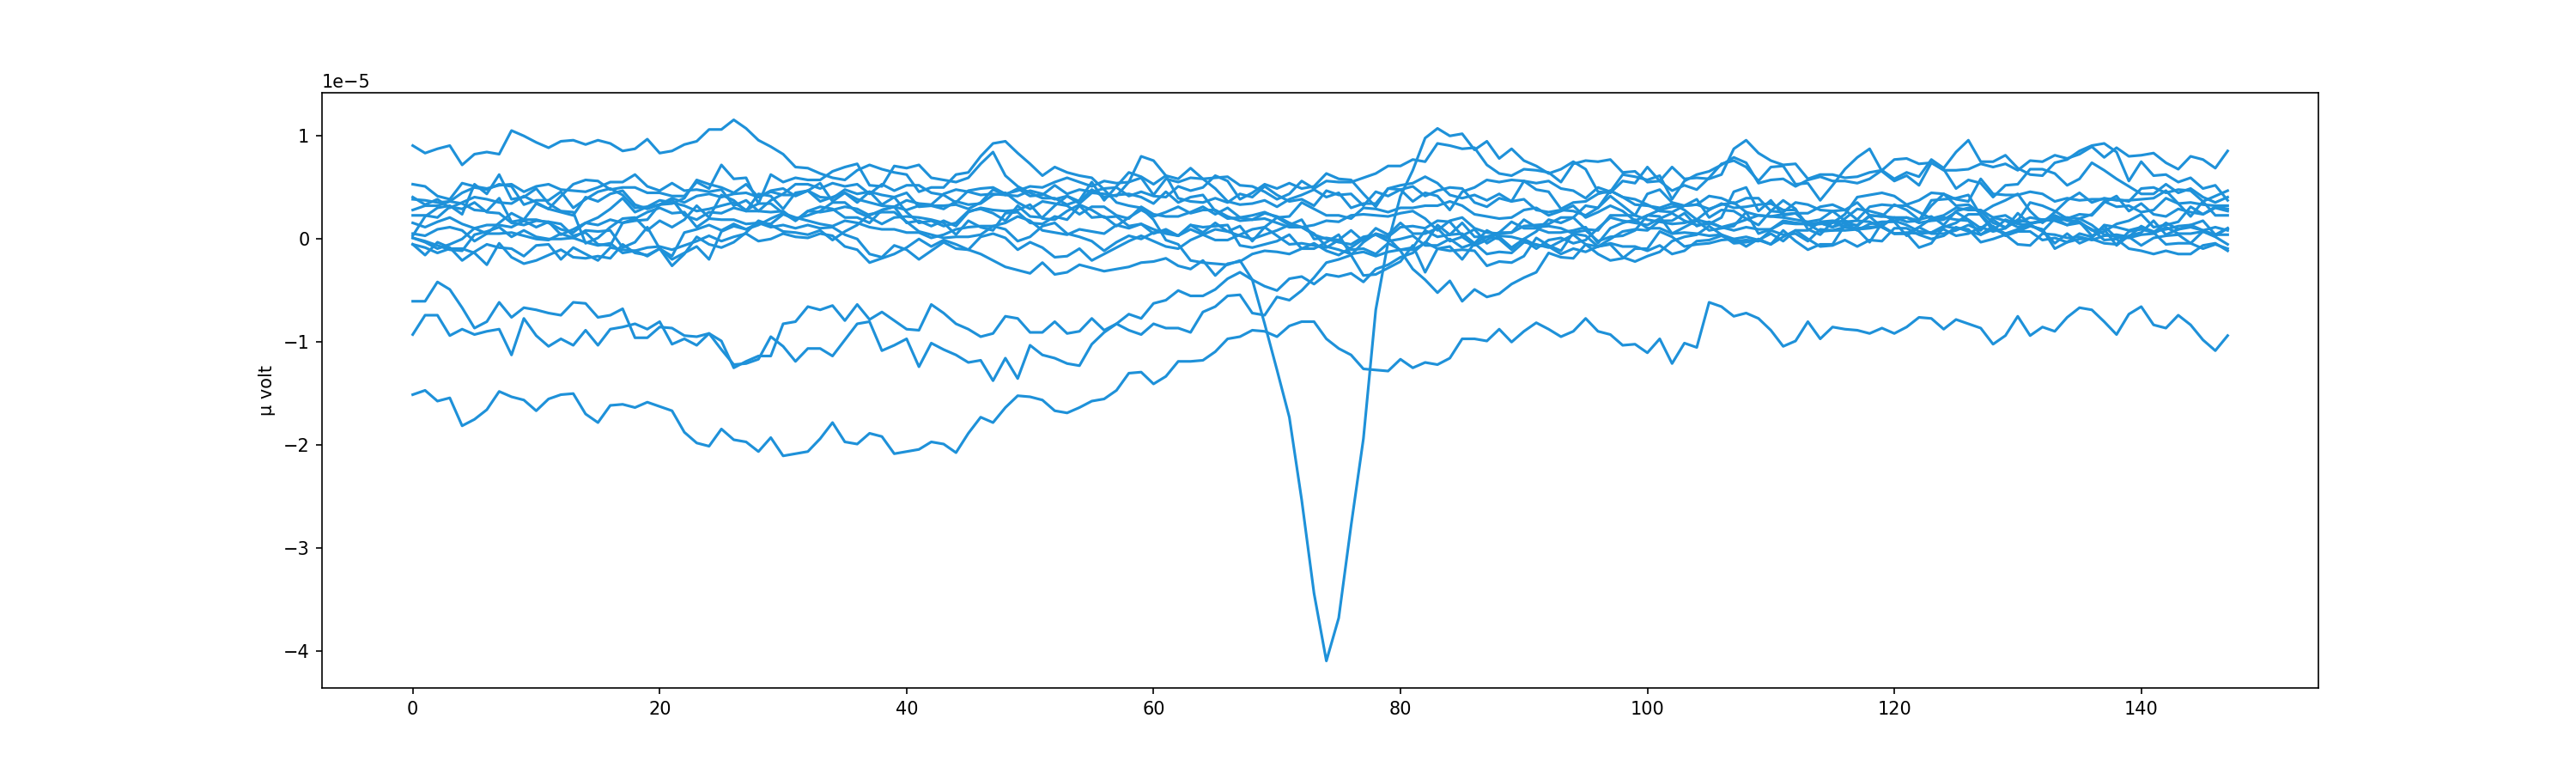

In [50]:
fig, ax = plt.subplots( figsize=(20,6))
ax = plt.plot(templates[2][:], c="#1E91D9")
ax = plt.ylabel('µ volt')

In [29]:
channel_map=np.load("channel_map.npy", allow_pickle=True)

In [30]:
channel_map_si=np.load('channel_map_si.npy', allow_pickle=True)

In [31]:
channel_positions=np.load('channel_positions.npy', allow_pickle=True)

In [32]:
channel_positions

array([[3000.,  800.],
       [2000., 1200.],
       [2600., 1200.],
       [2800., 1000.],
       [2000., 1400.],
       [2400., 1400.],
       [2200., 1600.],
       [3000., 1600.],
       [2600., 2000.],
       [2400., 1800.],
       [3000., 2400.],
       [2800., 2200.],
       [3000., 2800.],
       [2200., 2200.],
       [1800., 2000.],
       [1600., 1600.],
       [2000., 2800.],
       [2200., 3000.],
       [1600., 2400.],
       [1800., 2600.],
       [1400., 3000.],
       [1600., 2000.],
       [1200., 2400.],
       [1400., 2200.],
       [ 800., 2800.],
       [1000., 2600.],
       [2400.,  600.],
       [2600.,  400.],
       [3000.,  600.],
       [2000., 1000.],
       [2600., 1000.],
       [2800.,  800.],
       [2200., 1400.],
       [2400., 1200.],
       [2000., 1600.],
       [3000., 1400.],
       [2600., 1800.],
       [2400., 1600.],
       [3000., 2200.],
       [2800., 2000.],
       [1800., 1800.],
       [2000., 1800.],
       [2400., 2400.],
       [260

In [40]:
pcafeatures = np.load('pc_features.npy', allow_pickle=True)

In [41]:
np.shape(pcafeatures)

(1942902, 3, 16)

In [34]:
amplitudes=np.load('amplitudes.npy', allow_pickle=True)

In [36]:
len(amplitudes)


1942902

In [37]:
np.shape(amplitudes)

(1942902, 1)

In [40]:
float(amplitudes[0])

1.1562426152522676e-05

In [42]:
np.min(amplitudes)

5.2083e-07